# Hypothesis Testing with Insurance Data (Core)

- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

In [1]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy
scipy.__version__

'1.9.3'

In [2]:
# Load Data
df = pd.read_csv('insurance - insurance.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# - Q1. Do smokers have higher insurance charges than non-smokers?

1. State the Hypothesis & Null Hypothesis

(Null Hypothesis): There is no difference in higher insurance charges between smokers and non-smokers. 

(Alternative Hypothesis): There is a significant difference in higher insurance charges between smokers and non-smokers.

2. Determine the correct test to perform.

 - Numerical Data
 - Two groups/samples
 - We want to run a 2-sample T-test.



## Visualize and separate data for hypothesis

In [3]:
df['smokes'] = df['smoker'].str.contains('yes')
df['smokes'].value_counts()

False    1064
True      274
Name: smokes, dtype: int64

In [4]:
## save list of columns needed for each group
needed_cols = ['smokes','charges']

df[needed_cols]

,smokes,charges
0,True,16884.92400
1,False,1725.55230
2,False,4449.46200
3,False,21984.47061
4,False,3866.85520
...,...,...
1333,False,10600.54830
1334,False,2205.98080
1335,False,1629.83350
1336,False,2007.94500


In [5]:
## save non-smoker group in separate variable
non_smoker = df.loc[df['smokes']==False, needed_cols]
non_smoker

,smokes,charges
1,False,1725.55230
2,False,4449.46200
3,False,21984.47061
4,False,3866.85520
5,False,3756.62160
...,...,...
1332,False,11411.68500
1333,False,10600.54830
1334,False,2205.98080
1335,False,1629.83350


In [6]:
## save smoker group in separate variables
does_smoke = df.loc[df['smokes']==True, needed_cols]
does_smoke

,smokes,charges
0,True,16884.92400
11,True,27808.72510
14,True,39611.75770
19,True,36837.46700
23,True,37701.87680
...,...,...
1313,True,36397.57600
1314,True,18765.87545
1321,True,28101.33305
1323,True,43896.37630


<Axes: xlabel='smoker', ylabel='charges'>

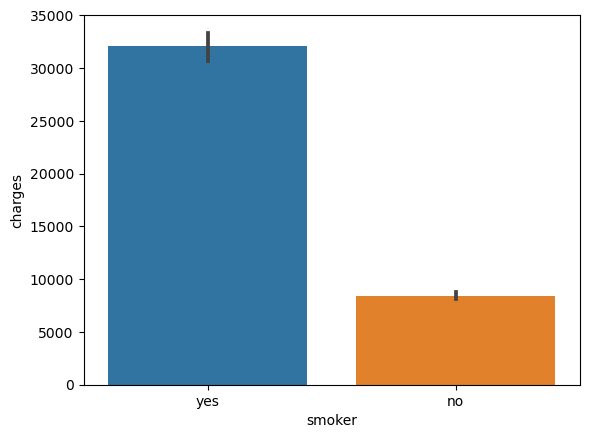

In [7]:
## visualize the group means
sns.barplot(data=df, x='smoker', y='charges')

## Testing Assumptions

   - No significant outliers
   - Normality
   - Uneven Variance



In [8]:
smoker_group = does_smoke['charges']
non_smoker_group =  non_smoker['charges']
non_smoker_group

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64

In [9]:
# Check female group for outliers
smoker_outlier = np.abs(stats.zscore(smoker_group)) > 3
smoker_outlier.sum()

0

In [10]:
# Check female group for outliers
non_smoker_outlier = np.abs(stats.zscore(non_smoker_group)) > 3
non_smoker_outlier.sum()

24

In [11]:
# Remove outliers from non smoker group
non_smoker_group = non_smoker_group.loc[~non_smoker_outlier]
non_smoker_group

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1040, dtype: float64

## Test for Normality

In [12]:
# Check smoker group for normality
result = stats.normaltest(smoker_group)
result.pvalue

5.564930630036463e-14

In [13]:
# Check n for smoker group
len(smoker_group)

274

In [14]:
# Check non-smoker group for normality
result = stats.normaltest(non_smoker_group)
result.pvalue

2.6945416315543976e-36

In [15]:
# Check n for non-smoker group
len(non_smoker_group)

1040

Since our p-values from our normality test are small it shows evidence against the null hypothesis in favor of the alternative.

Are groups are large enough that we can safely disregard the assumption of normality.



## Test for Equal Variances

In [16]:
# Use Levene's test for equal variance
result = stats.levene(smoker_group, non_smoker_group)
print(result)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


In [17]:
# Interpret the p-value
if result.pvalue < .05:
    print(f"The groups do NOT have equal variance.")
else:
    print(f"The groups DO have equal variance.")

The groups do NOT have equal variance.


- We NOT meet the assumption of equal variance.
- We will therefore run a Welch's t-test instead by adding equal_var=False to stats.ttest_ind



## Final Hypothesis Test - Welch's T-Test


In [18]:
result = stats.ttest_ind(smoker_group, non_smoker_group, equal_var=False)
print(result)
result.pvalue  < .05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

In [19]:
smoker_group.mean()

32050.23183153284

In [20]:
non_smoker_group.mean()

7939.8608446721155

We had a p-value < .05 for our welch's t-test. We reject the null hypothesis and support the alternative that there is a significant difference in higher insurance charges between smokers and non-smokers.


# Q2: Are men more likely to smoke than women?

1. State the Hypothesis & Null Hypothesis

(Null Hypothesis): There is no difference in men being more likely to smoke than women. 

(Alternative Hypothesis): There is a significant difference in men being more likely to smoke than women.

2. Determine the correct test to perform.

 - Categorical Data
 - 2 group/samples
 - We want to run a Chi-Square test.


In [21]:
# Load new data
# Load Data
df1 = pd.read_csv('insurance - insurance.csv')
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Text(0.5, 1.0, 'Smokers vs. Non-Smokers based on Sex')

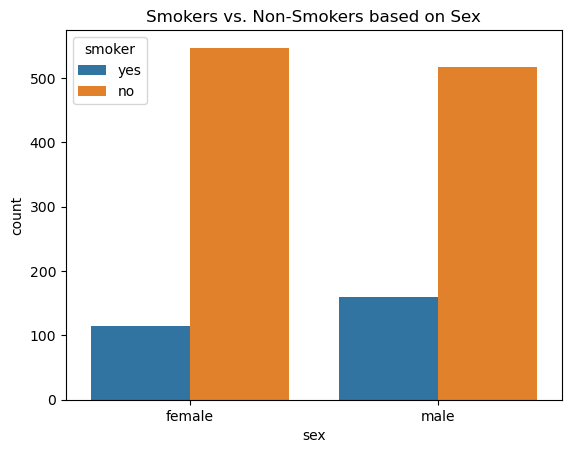

In [22]:
# Visualize data
ax = sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title('Smokers vs. Non-Smokers based on Sex')

## Creating Contingency Table

In [23]:
table = pd.crosstab(df1['sex'], df1['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


## Final Hypothesis Test

In [24]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [25]:
# What was our p-value?
print(p)
p <.05

0.006548143503580696


True

In [41]:
table

smoker,no,yes
sex,,
female,547,115
male,517,159


- Since the p-value is less than .05 we will reject our null hypothesis and supported the alternative hypothesis. This concludes that their is a significant difference in men being more likely to smoke than women.

# Q3: Do different regions have different charges, on average?

1. State the Hypothesis & Null Hypothesis

(Null Hypothesis): There is no difference in charges on average for different regions 

(Alternative Hypothesis): There is a significant difference in charges on average for different regions.

2. Determine the correct test to perform.

 - Numerical Data
 - More than two groups/samples
 - We want to run an ANOVA test.


In [26]:
# Load new data
# Load Data
df2 = pd.read_csv('insurance - insurance.csv')
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [27]:
df2['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Visualize and separate data for hypothesis

   - What column is our target?
   - What column determines our groups?



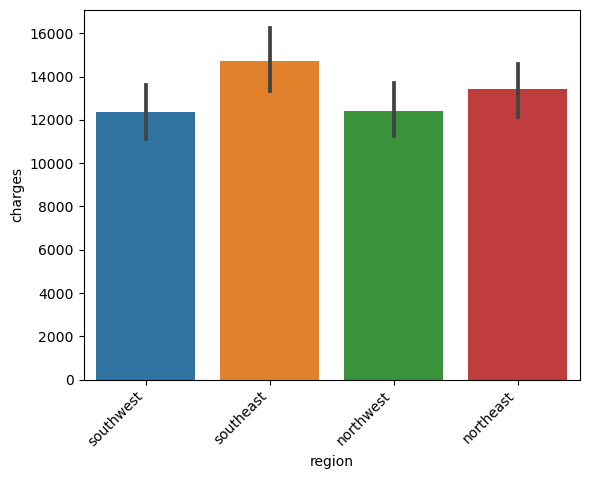

In [28]:
ax = sns.barplot(data=df2, x='region', y='charges')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

In [29]:
needed_cols = ['region','charges']
df2[needed_cols]



,region,charges
0,southwest,16884.92400
1,southeast,1725.55230
2,southeast,4449.46200
3,northwest,21984.47061
4,northwest,3866.85520
...,...,...
1333,northwest,10600.54830
1334,northeast,2205.98080
1335,southeast,1629.83350
1336,southwest,2007.94500


In [30]:
## Create a dictionary with each group as key and charges as values
groups ={}

for region in df2['region'].unique():
    temp = df2.loc[df2['region']== region, 'charges']
    groups[region] = temp

groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [31]:
# Test one of the groups
groups['southeast']

1        1725.5523
2        4449.4620
5        3756.6216
6        8240.5896
11      27808.7251
           ...    
1322    12981.3457
1323    43896.3763
1327     9377.9047
1330    12629.1656
1335     1629.8335
Name: charges, Length: 364, dtype: float64

Testing Assumptions

- No significant outliers
- Normality
- Equal Variance


## Checking Assumption of No Sig. Outliers



In [32]:
# Loop through groups dict
for region, data in groups.items():

    ## determine if there are any outliers
    outliers = np.abs(stats.zscore(data)) > 3
    
    ## print a statement about how many outliers for which group name
    print(f"There were {outliers.sum()} outliers in the {region} group.")

    ## Remove the outiers from data and overwrite the sector data in the dict
    data = data.loc[~outliers]
    groups[region] = data

There were 8 outliers in the southwest group.
There were 2 outliers in the southeast group.
There were 7 outliers in the northwest group.
There were 4 outliers in the northeast group.


## Test for Normality

In [33]:
# Running normal test on each group and confirming 
# there are >20 in each group

# Save a list with an inner list of column names
norm_results = [['group','n','pval','sig?']]


## loop through group dict
for region, data in groups.items():
    ## calculate normaltest results
    stat, p = stats.normaltest(data)
    
    ## Append the right info into norm_resutls (as a list)
    norm_results.append([region,len(data), p, p<.05])
    
    
## Make norm_results a dataframe (first row is columns, everything else data)
normal_results = pd.DataFrame(norm_results[1:], columns = norm_results[0])
normal_results

,group,n,pval,sig?
0,southwest,317,7.728611e-22,True
1,southeast,362,1.936990e-13,True
2,northwest,318,2.940543e-19,True
3,northeast,320,3.557877e-17,True


Assumption of normality was failed, but our groups are large enough that we can safely disregard/ignore the assumption of normality.

## Test for Equal Variances

In [34]:
#Use Levene's test for equal variance
result = stats.levene(*groups.values())
print(result)

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)


In [35]:
# Interpret the p-value
if result.pvalue < .05:
    print(f"The groups do NOT have equal variance.")
else:
    print(f"The groups DO have equal variance.")



The groups do NOT have equal variance.



- We met the assumption of normality but did NOT meet the assumption of equal variance.
- Because of this we are using a Kurskal-Wallis test instead.



## Final Hypothesis Test


In [36]:
# Running Krukal Test for Original Hypothesis
result = stats.kruskal(*groups.values())
print(result)
result.pvalue<.05

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)


False

Our final test returned a p-value slightly above .05. We fail to reject the null hypothesis and their is no difference in charges on average for different regions.

In [37]:
southwest_mean = df.loc[df['region'].str.contains('southwest'), needed_cols]
southwest_mean['charges'].mean()

12346.937377292308

In [38]:
southeast_mean = df.loc[df['region'].str.contains('southeast'), needed_cols]
southeast_mean['charges'].mean()

14735.411437609888

In [39]:
northwest_mean = df.loc[df['region'].str.contains('northwest'), needed_cols]
northwest_mean['charges'].mean()

12417.57537396923

In [40]:
northeast_mean = df.loc[df['region'].str.contains('northeast'), needed_cols]
northeast_mean['charges'].mean()

13406.384516385804